# Benchmarks of different version of Cross Correlations

Author: Cody W. Eilar



In this notebook, I explore speed comparisons of several different methods of implementing cross correlation in C++. All these experiments were done using a kernel that is 17x17.

In [46]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


## Table of Values
In the below table, I compare four different methods for implementing cross correlation. 

- `NoGpuSupport` - this is OpenCV's normal implementation of cross correlation using the `matchTemplate` function. 
- `GpuSupport` - This is OpenCV's GPU implementation of the `matchTemplate` function. 
- `Decompose` - This is somewhat of a dummy test that demonstrates the maximum speed that overlap and add could work. This does not include any addtions or memory copies. It just calculates how long it takes to compute the cross correlation multiple times based on what value the image would be broke up. i.e. if the `L` value is set to 512, there would be a total of 4 cross correlation operations for a 1024x1024 image. 
- `OverlapAdd` - This benchmark demonstrates my implementation of overlap and add for a 2D signal.

In the table below, `Problem Space` is referring to the image size, i.e. 512 means that the image is 512x512. 

In [53]:
data = pd.read_csv("./cross_correlation_results.csv")
data[['Experiment', 'Problem Space', 'Baseline', 'Iterations/sec', 'Min (us)', 'Mean (us)',
      'Max (us)', 'Standard Deviation']]

,Experiment,Problem Space,Baseline,Iterations/sec,Min (us),Mean (us),Max (us),Standard Deviation
0,NoGpuSupport,512,1.000000,340.69200,14676,20277.300,30644,8987.5200
1,NoGpuSupport,1024,1.000000,95.08600,52584,53188.700,54085,791.8660
2,NoGpuSupport,2048,1.000000,19.32700,258706,312162.000,393190,71356.0000
3,NoGpuSupport,4096,1.000000,5.20190,961188,5034320.000,12925656,6835280.0000
4,NoGpuSupport,8192,1.000000,1.10492,4525209,19837100.000,50431764,26495800.0000
5,GpuSupport,512,0.023167,14705.90000,340,925.333,2083,1002.5900
6,GpuSupport,1024,0.005401,17605.60000,284,336.000,373,46.3573
7,GpuSupport,2048,0.001473,13123.40000,381,667.667,1123,398.7200
8,GpuSupport,4096,0.001002,5192.11000,963,1037.330,1088,65.7749
9,GpuSupport,8192,0.013229,83.52540,59862,62917.300,66453,3321.6500


## Plotted results
In the following plot, I visually demonstrate the statistics for `Iterations/sec`. These are plotted using log scaling so that smaller values can easily be seen. 

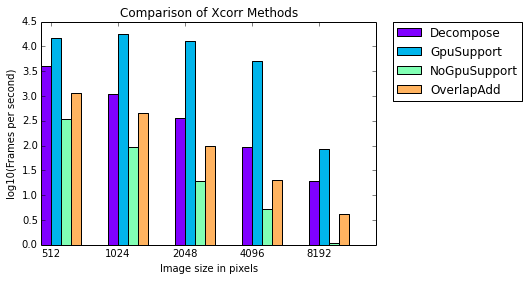

In [52]:
import matplotlib.cm as cm
prob_space = data.groupby('Experiment')
ind = np.arange(len(data.groupby('Problem Space')))
colors = cm.rainbow(np.linspace(0, 1, len(ind)))

fig, ax = plt.subplots()
width = .15; 
offset = 0
rects = []
names = []
for (name, group), c in zip(prob_space, colors): 
    names.append(name)
    rects.append(ax.bar(ind +offset, np.log10(group['Iterations/sec']), width, color=c))
    offset = offset + width
    
ax.set_ylabel('log10(Frames per second)')
ax.set_xlabel('Image size in pixels')
ax.set_title('Comparison of Xcorr Methods')
ax.set_xticks(ind + width)
ax.set_xticklabels(data['Problem Space'].unique())
ax.legend(rects, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Results
From the plot above, we can see that the best implementation, even for large images (8k x 8k), is the GPU supported `matchTemplate` function available in OpenCV. As we would expect, the `decompose` experiment is always better than the `OverlapAdd` experiment but is never able to beat out the `GpuSupport` experiment. Despite all this, all GPU implementations significantly beat ou the CPU only implementation. Experiments were also attempted using 16k x 16k images, but I found that there wasn't sufficient memory on the GPU to handle images of this size. In that regard, overlap and add can easily handle images of arbitrary size. 